# 05.Transfer Learning with TesnsorFlow Part 2: Fine-tuning

오늘 배운 핵심 개념:
- fine-tuning transter leanring : 이미 훈련된 모델의 가중치를 다른 모델에 적용한 후 세부 사항을 조정 하여 다른 모델의 학습 데이터에 맞게 함.

- Feautre extractoin transer learning과 fine-tuning transfer learning의 가장 주요한 차이점 :
    - fine-tuning 에서는 사전 학습된 모델의 더많은 층을 동결 해제(unfreeze)하여 사용자 정의 데이터에 맞게 조정(tune) 함. 이러한 fine-tuning은 일반적으로 feature extraction보다 더 많은 데이터가 있어야 효과적임

- `include_top = False` : 최상단의 분류 레이어를 제거함.
    - 사전 학습되 모델의 'feature extractor' 부분만 사용하고, 최상단의 classifier는 새롭게 구축한다는 의미. 기존의 모델과 클래스 수가 다르면 사용할 수 없기 때문

- `trainable=False` : 이 모델의 가중치를 훈련시키 않겠다는 의미. 즉 이미 생성된 가중치를 이용함. 고정된 특성 추출기로 사용하겠다는 의미

- `Sequential API`와 `Functional API`의 차이점
    - Sequential API :
    - 레이어를 순차적으로 하나씩 쌓는 구조
    - 단일 입출력만 가능
    - 간단한 모델에 적합함
    - Functional API 보다 유연성이 낮음.
    - 입출력이 여러 개이거나, 레이어가 병렬로 연결되어야 하거나 중간 출력이 재사용 되너야 하는 복잡한 모델은 구성할 수 없음
    - Functional API:
    - 레이어를 함수처럼 연결해서 사용
    - 복잡한 구조 가능
    - 유연하고 강력한 모델 정의 방식임.
    - 전이 학습, Gan, AutoEncoder 등에 적합함.

- 학습 모델을 구현할 때, 모델 안에 데이터 증강 층을 구현했는데. (이전에 있었던 모델들은 사전 처리 단계에서 데이터 증강한 데이터를 학습하는 방향으로 진행하였음.) 이번 모델처럼 모델의 일부로 포함시키면 아래의 장점이 있음. 또한, 해당 증강은 훈련일 경우에만 작동함.
    - `fit()` 시점에 매 배치마다 다르게 증강
    - 코드가 깔끔하고 직관적
    - GPU 상에서 바로 실행되어 속도도 빠름.



##  What we're going to cover

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Kears Fuctional API (a differnt way to build models in Keras)
- Using a samller dataset to experiment faster (e.g. 1-10% of trainging samples of 10 classes of food)
- Data augmentation (how to maek your trainging dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
    - Model 0 : a transer leaning model using the Keras Functional API
    - Model 1 : a feature extraction transfer learning model on 1% of the data with data augmentation
    - Model 2 : a feature extraction transfer learning model on 10% of the data with data qugmentation
    - Model 3: a fine-tuned transfer learningmodel on 10% of the data
    - Model 4: a fine-tuned transfer leanring model on 1000% of the data
- Introduce the ModelCheckpoint callback to save intermediate trainging results
- Compare model experiments results using TensorBoard

In [172]:
import datetime
print(f"Notebook last run (end-to-end) : {datetime.datetime.now()}")

Notebook last run (end-to-end) : 2025-06-01 14:13:01.773300


In [173]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [174]:
!nvidia-smi

Sun Jun  1 14:13:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |    2172MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [175]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2025-06-01 14:13:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-01 14:13:02 (136 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



## 10 Food classes: Working with less data

tf.keras.applications : <br>
image_dataset_from_directory() :  <br>
tf.keras.utils <br>

In [176]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-06-01 14:13:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 4.6s    

2025-06-01 14:13:06 (35.2 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [177]:
#  Walk through 10 percent data dire tory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [178]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [179]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical", # what type are the labels?
                                                                            batch_size = 32) # batch_size is 32 by default, ths is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


`image_dataset_from_directry()`
- `diretory` : the filepath of the target directory we're loading images in from.
- `image_size` : the target size ot rhe images we're going to load in (height, width)
- `batch_size` : the batch size og the images we're goingto load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.


In [180]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [181]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [182]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.69132652e+01 2.11989803e+01 2.55561218e+01]
   [4.23061256e+01 5.10204124e+01 5.60918427e+01]
   [5.74897957e+01 6.80612259e+01 7.47040787e+01]
   ...
   [1.57989899e+02 1.49775635e+02 1.45918579e+02]
   [1.64280548e+02 1.58280548e+02 1.58280548e+02]
   [1.51530518e+02 1.47530518e+02 1.48530518e+02]]

  [[1.27908173e+01 1.58826532e+01 2.08367348e+01]
   [2.60408173e+01 3.56173477e+01 3.79591866e+01]
   [6.12244911e+01 7.17959213e+01 7.84387741e+01]
   ...
   [1.46413269e+02 1.38199005e+02 1.34341949e+02]
   [1.58280624e+02 1.52280624e+02 1.52280624e+02]
   [1.56382584e+02 1.52382584e+02 1.53382584e+02]]

  [[1.44387751e+01 1.68622456e+01 2.15102043e+01]
   [1.61428566e+01 2.39285717e+01 2.70000000e+01]
   [4.90153046e+01 6.00153046e+01 6.44438782e+01]
   ...
   [1.46403107e+02 1.38617371e+02 1.34546051e+02]
   [1.61770401e+02 1.55801025e+02 1.55785721e+02]
   [1.51846756e+02 1.47846756e+02 1.48846756e+02]]

  ...

  [[3.62755470e+01 3.02755470e+01 3.22755470e+01]
   [3

## Model 0: Building a transfer learning


In [183]:
# 1. create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model( so the pre-learned patterns remain)
base_model.trainable = False

# 3.Create input into the mase model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. If using ResNet50V2, add this to speed up convergnece, remove for effiecientNetV2
# X = tf.keras.layers.experimental.preprocessing.Resczaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note : usnit tf.keras.applications, EfficientNetV2 inputs don't have tobe normalized)
x = base_model(inputs)
# check data shape after passing it to base_model

# 6. Average pool the outputs of the base model (aggregate all the most important information, redue number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# 8. Combine the inputs with the output into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Complie the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the mode ( we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 # Go through lee of the validation data so epoch are faster (we want faster experiments)
                                 validation_steps = int(0.25 * len(test_data_10_percent)),
                                 #  Track out model's training logs for viusalization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250601-141311
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 787ms/step - accuracy: 0.2468 - loss: 2.1294 - val_accuracy: 0.7336 - val_loss: 1.3662
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.7335 - loss: 1.2596 - val_accuracy: 0.8141 - val_loss: 0.9331
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8134 - loss: 0.8825 - val_accuracy: 0.8339 - val_loss: 0.7473
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8386 - loss: 0.7436 - val_accuracy: 0.8520 - val_loss: 0.6446
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8583 - loss: 0.6230 - val_accuracy: 0.8750 - val_loss: 0.5722


In [184]:
# check layes in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_35
1 rescaling_31
2 normalization_31
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_

In [185]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_31        │ (None, None,      │          0 │ input_layer_35[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_31    │ (None, None,      │          0 │ rescaling_31[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_31… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [186]:
# Check sumamro of model constructed with Functional API
model_0.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

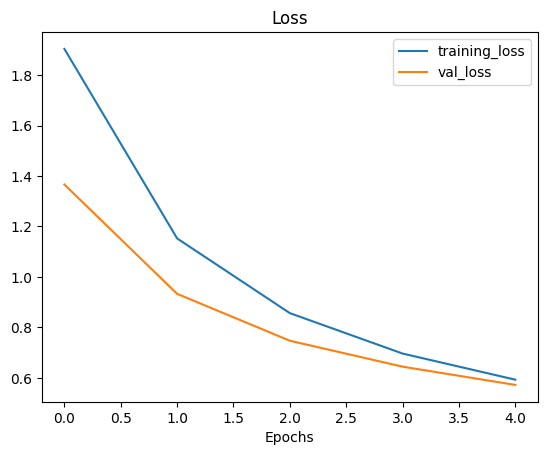

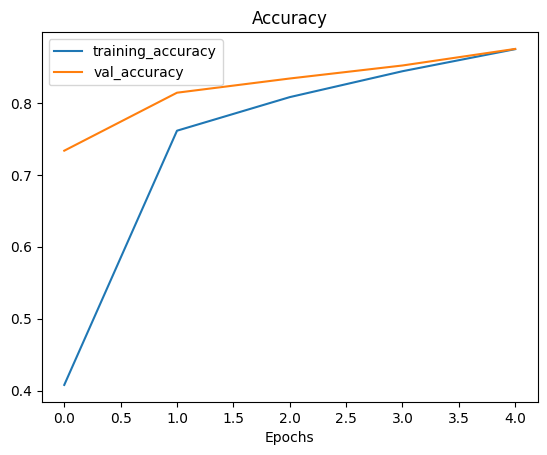

In [187]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vetor form a trained model

- `tf.keras.layers.GlobalAveragePooling2D()` : layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes

In [188]:
# Define input tnesor shpe (same number of dimensions as th output of efficientnetv2-b0)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the diffenrent tensors
print(f"shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor : {global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor : (1, 3)


In [189]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis = [1,2]) # aveage across the middel axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [190]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-06-01 14:14:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.5’

10_food_classes_1_p 100%[===================>] 127.42M  40.4MB/s    in 3.6s    

2025-06-01 14:14:24 (35.0 MB/s) - ‘10_food_classes_1_percent.zip.5’ saved [133612354/133612354]



In [191]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = '10_food_classes_1_percent/test/'

In [192]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [193]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size = 32, # default
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model


In [194]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.Layers.experimenta import preprocessing

# NEW : Newer version of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data aumentation
data_augmentation = keras.Sequential([
    layers.InputLayer(input_shape = IMG_SIZE + (3,), name = "data_augmentation_input"), # 명식적으로 input shape 을 알려주자.
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # Preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficeintNetV2B0
], name = "data_augmentation")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


img.shape : (512, 512, 3)


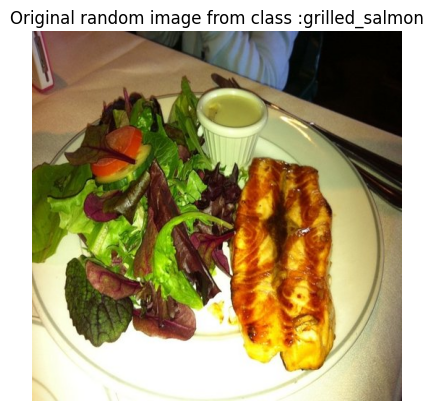

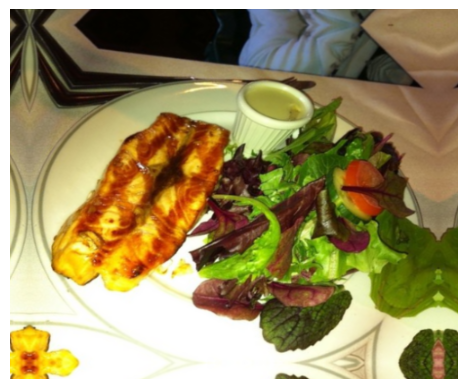

In [195]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # choos a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random iamge path
img = mpimg.imread(random_image_path) # read in the chosen target image
print(f"img.shape : {img.shape}")
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class :{target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0)) # data augmentation model required shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # required normaliztion after augmentation
plt.axis(False);


## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation

In [196]:
# Setup input shpae and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

print(base_model.input_shape)

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequentail model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmetation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dnes layer on as the output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)), # validate for less steps
                                # Track model training logs
                                callbacks = [create_tensorboard_callback("transfer_learning","1_percent_data_aug")])

(None, None, None, 3)
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250601-141428
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.0826 - loss: 2.4296 - val_accuracy: 0.1349 - val_loss: 2.2751
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - accuracy: 0.1853 - loss: 2.1671 - val_accuracy: 0.1941 - val_loss: 2.1765
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - accuracy: 0.3693 - loss: 2.0309 - val_accuracy: 0.2747 - val_loss: 2.0627
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 786ms/step - accuracy: 0.4844 - loss: 1.9074 - val_accuracy: 0.3553 - val_loss: 1.9815
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5371 - loss: 1.7220 - val_accuracy: 0.4260 - val_loss: 1.8868


In [197]:
# Check out model summary
model_1.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [198]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4243 - loss: 1.8858


[1.8786529302597046, 0.43320000171661377]

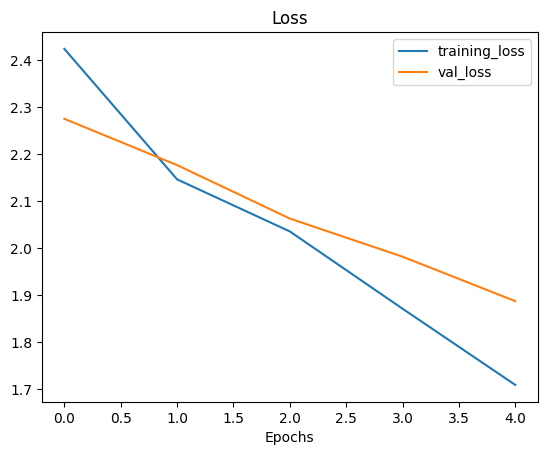

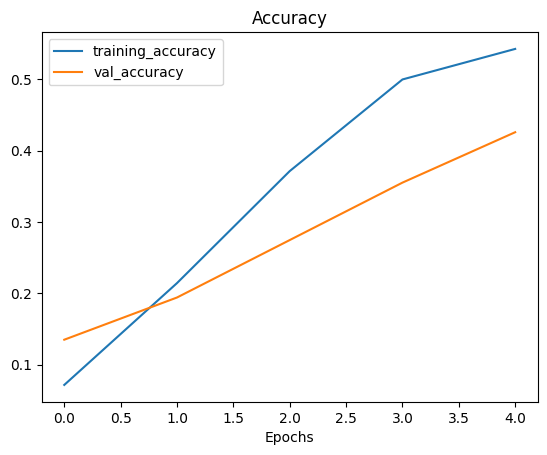

In [199]:
# How does the mdoel go with data augmentations layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2 :Featuer extraction transferlearning with 10% of data and data augmentation

In [200]:
# Get 10% of the data ot the 10 classes(uncomment if you haven't gotten "10%_fopd_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2025-06-01 14:15:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.6’

10_food_classes_10_ 100%[===================>] 160.74M  42.3MB/s    in 4.4s    

2025-06-01 14:15:09 (36.2 MB/s) - ‘10_food_classes_10_percent.zip.6’ saved [168546183/168546183]



In [201]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

In [202]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_10_percent,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode = "categorical")



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [203]:
# check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [204]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [205]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)


tf.Tensor(
[[[[8.83163300e+01 6.53163300e+01 4.93163261e+01]
   [8.72602005e+01 6.31887741e+01 4.62602043e+01]
   [8.85765305e+01 6.23571434e+01 4.47908173e+01]
   ...
   [1.38265333e+01 1.29642744e+01 1.09642744e+01]
   [1.23417816e+01 8.34178162e+00 5.34178162e+00]
   [1.28318043e+01 8.54609013e+00 4.18894768e+00]]

  [[8.54234695e+01 5.93520432e+01 4.64948997e+01]
   [9.31326523e+01 6.51326523e+01 5.12755089e+01]
   [9.24285736e+01 6.48877563e+01 4.82704086e+01]
   ...
   [1.18927155e+01 1.00662470e+01 6.73455381e+00]
   [1.09234686e+01 6.92346859e+00 3.92346859e+00]
   [1.54542236e+01 1.24542236e+01 7.45422363e+00]]

  [[7.34438782e+01 4.64438782e+01 3.70153084e+01]
   [9.14030609e+01 6.41887741e+01 5.29744911e+01]
   [9.08571472e+01 6.24744911e+01 4.96173477e+01]
   ...
   [1.67193356e+01 1.25050726e+01 9.50507259e+00]
   [1.08826704e+01 7.66838455e+00 3.09695649e+00]
   [1.65153980e+01 1.35153980e+01 8.51539803e+00]]

  ...

  [[3.86175575e+01 4.40461426e+01 3.76175575e+01]
   [2

In [206]:
# 1. Create base model with tf.keras.pplication
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model ( so thepre_learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.Layers.experimental.preprocessing.Recscaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note : using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check dat shape after passing it to base_model
print(f"Shape after base_model :{x.shape}")

# 6. Average poorl the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalQveragePooling2D():{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine the input swith the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model (we use less stemp for validations so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 # Go through less of the validation data so epochs are fater (we want faster experiments!)
                                 validation_steps = int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks = [create_tensorboard_callback("transfer_learning","10_percent_featur_extract")])


Shape after base_model :(None, 7, 7, 1280)
After GlobalQveragePooling2D():(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_featur_extract/20250601-141512
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 790ms/step - accuracy: 0.2675 - loss: 2.1371 - val_accuracy: 0.7632 - val_loss: 1.3115
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7202 - loss: 1.2919 - val_accuracy: 0.8306 - val_loss: 0.8748
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7866 - loss: 0.9330 - val_accuracy: 0.8487 - val_loss: 0.6785
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8037 - loss: 0.7420 - val_accuracy: 0.8684 - val_loss: 0.5893
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8664 - loss: 0.6125 - val_accuracy: 0.8651 - val_loss: 0.5418


In [207]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_37
1 rescaling_33
2 normalization_33
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_

In [208]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_33        │ (None, None,      │          0 │ input_layer_37[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_33    │ (None, None,      │          0 │ rescaling_33[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_33… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [209]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

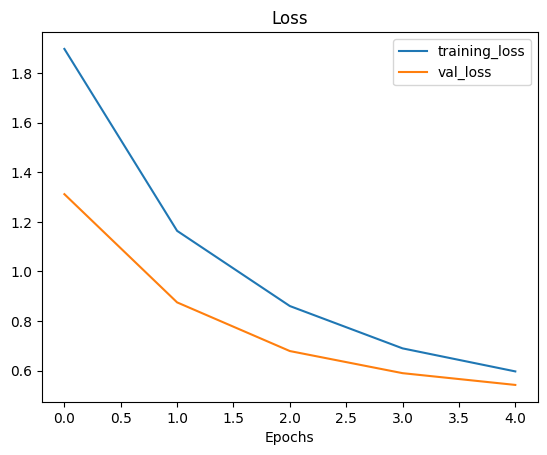

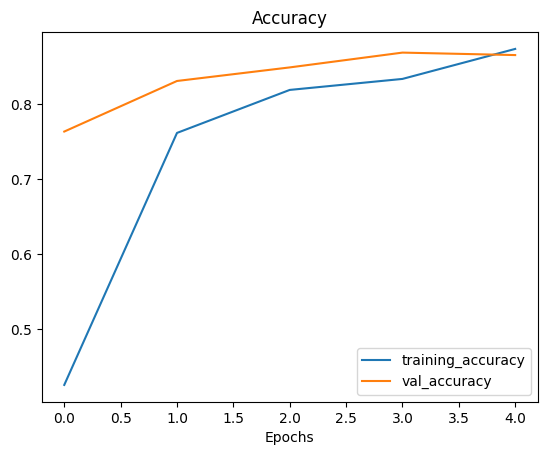

In [210]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from trained model

In [211]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a globa average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of 2D global average pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of 2D global average pooled input tensor: (1, 3)


In [212]:
# this is the same asBlobalAVeragePooling2D()
tf.reduce_mean(input_tensor, axis = [1,2]) # average across the middle axes


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [213]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percnet = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2025-06-01 14:16:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.250.153.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.6’

10_food_classes_1_p 100%[===================>] 127.42M  38.2MB/s    in 3.8s    

2025-06-01 14:16:18 (33.3 MB/s) - ‘10_food_classes_1_percent.zip.6’ saved [133612354/133612354]



In [214]:
# Waltk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [215]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_1_percnet = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           batch_size = 32, # default
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [216]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentaion = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = "data_augementation")

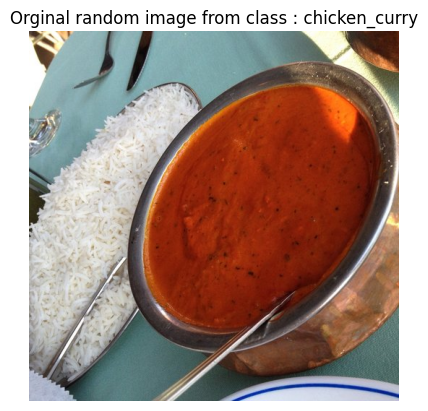

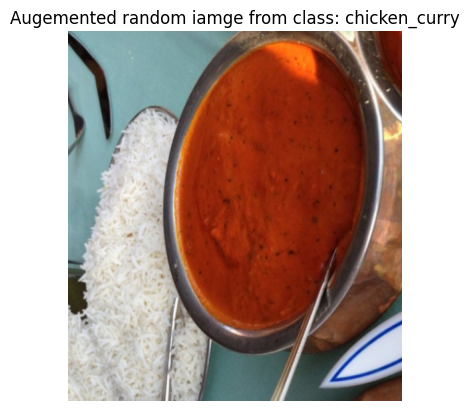

In [217]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percnet.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the tatget directory
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img)
plt.title(f"Orginal random image from class : {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0)) # data augmentation model required shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.)) # required normalization ager augmentation
plt.title(f"Augemented random iamge from class: {target_class}")
plt.axis(False);

## Model 1: Feature extractiontransfer leaning on 1% of the data with data augmentation

In [218]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_lyaer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"]
                )

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # validate for less steps
                                # Track model training logs
                                callbacks = [create_tensorboard_callback("transfer_learning","1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250601-141621
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1079 - loss: 2.3502 - val_accuracy: 0.1678 - val_loss: 2.2248
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2432 - loss: 2.2251 - val_accuracy: 0.2451 - val_loss: 2.1260
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2711 - loss: 2.0066 - val_accuracy: 0.3158 - val_loss: 2.0331
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 725ms/step - accuracy: 0.4662 - loss: 1.8854 - val_accuracy: 0.3618 - val_loss: 1.9719
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.5748 - loss: 1.7310 - val_accuracy: 0.4243 - val_loss: 1.8695


In [219]:
# Chek out model summary
model_1.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_lyaer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [220]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4119 - loss: 1.8745


[1.8559658527374268, 0.42239999771118164]

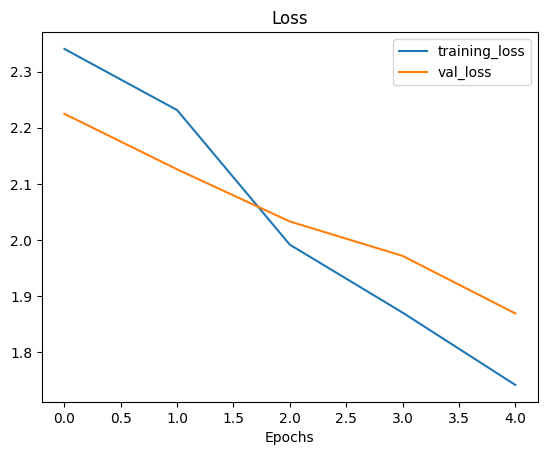

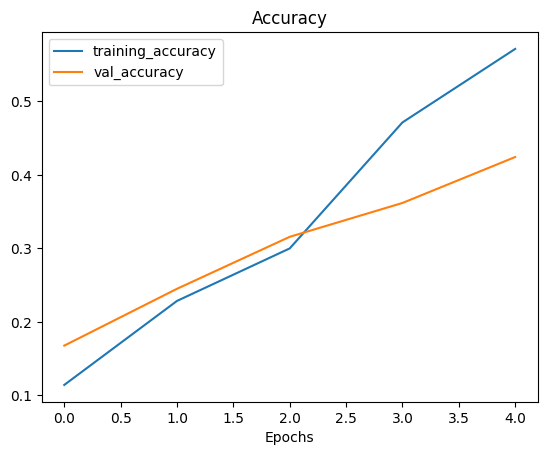

In [221]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transer learning with 10% of data and data augmentation

In [222]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-06-01 14:17:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.7’

10_food_classes_10_ 100%[===================>] 160.74M  41.5MB/s    in 4.5s    

2025-06-01 14:17:22 (35.5 MB/s) - ‘10_food_classes_10_percent.zip.7’ saved [168546183/168546183]



In [223]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

In [224]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [225]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = keras.Sequential([
    layers.InputLayer(input_shape = IMG_SIZE + (3,), name = "input_layer"), # 명시적으로 input shape 을 알려주자.
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name = "input_layer") # Create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented image to base model but keep it in inference mode, so batchnorm layers don't get updated:
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name ="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), # use Adam optimizer with base learning rate
                metrics = ["accuracy"])



In [226]:
def create_base_model(input_shape: tuple[int, int, int] =  (224,224,3),
                      output_shape : int = 10,
                      learning_rate : float = 0.001,
                      training : bool = False )-> tf.keras.Model:
    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = False

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape = input_shape, name = "input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False) # pass augmented image to base model but keep it in interence mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units = output_shape, activation = "softmax", name = "output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss = "categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instace of model_2 with our new function
model_2 = create_base_model()

## Creating a ModelCheckpoint callback

In [227]:
# Setup check point path
checkpoint_path = "ten_percent_model_checkpoitns_wights/checkpoint.ckpt.weights.h5" # note : remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback tat saves the model's wights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True, # set to Flase to save the entire model
                                                         save_best_only = True, # save only the best model weights instead of a model every epoch
                                                         save_freq = "epoch", # save every epoch
                                                         verbose = 1)

In [228]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)), # to less steps per validation (quicker)
                                          callbacks = [create_tensorboard_callback("transfer_learning","10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250601-141726
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.1838 - loss: 2.2833
Epoch 1: val_loss improved from inf to 1.64181, saving model to ten_percent_model_checkpoitns_wights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - accuracy: 0.1879 - loss: 2.2764 - val_accuracy: 0.5592 - val_loss: 1.6418
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5799 - loss: 1.5473
Epoch 2: val_loss improved from 1.64181 to 1.16519, saving model to ten_percent_model_checkpoitns_wights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - accuracy: 0.5809 - loss: 1.5442 - val_accuracy: 0.7039 - val_loss: 1.1652
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6704 - loss: 1.2264
Epoch 3: val_loss improved from 1.16519 to 0.94127, saving model to ten_percent_model_checkpoitns_wights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s

In [229]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8154 - loss: 0.6959


[0.7027450203895569, 0.8104000091552734]

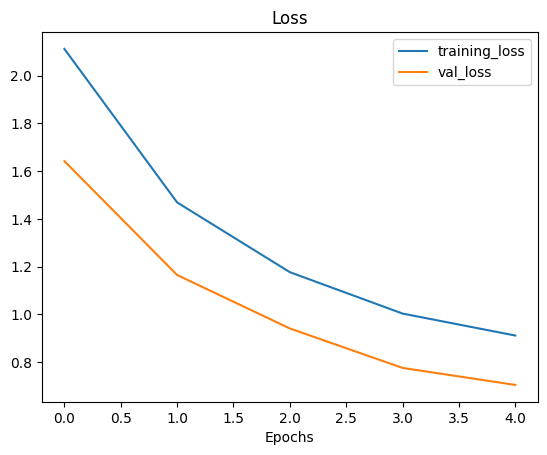

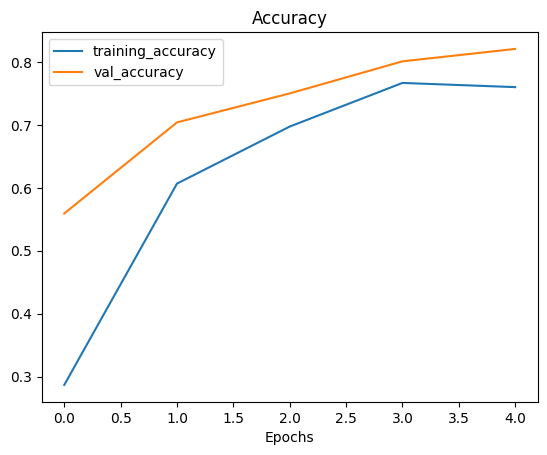

In [230]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [231]:
# Load in save model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8145 - loss: 0.7018


In [232]:
# IF the results from our native model and teh loaded weights are the same, this should output true
results_10_percent_data_aug == loaded_weights_model_results

True

In [233]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [234]:
# Check the difference betwwen the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

In [235]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [236]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer number :{layer_number} | Layer name :{layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number :0 | Layer name :input_layer | Layer type: <InputLayer name=input_layer, built=True> | Trainable? True
Layer number :1 | Layer name :data_augmentation | Layer type: <Sequential name=data_augmentation, built=True> | Trainable? True
Layer number :2 | Layer name :efficientnetv2-b0 | Layer type: <Functional name=efficientnetv2-b0, built=True> | Trainable? False
Layer number :3 | Layer name :global_average_pooling_layer | Layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number :4 | Layer name :output_layer | Layer type: <Dense name=output_layer, built=True> | Trainable? True


In [237]:
model_2.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [238]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [239]:
# How may layers are trainable in our model_2 base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientnetV2B0 layer (the base model)

0


In [240]:
# check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_40 False
1 rescaling_36 False
2 normalization_36 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [241]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), #lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [242]:
# Check wich laeyrs are tuneable(trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_40 False
1 rescaling_36 False
2 normalization_36 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [243]:
print(len(model_2.trainable_variables))

12


In [244]:
# Fine tune for another 3 epochs
fine_tune_epochs = initial_epochs +5

# Refit the model (same as mdoel_2 excep with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data = test_data,
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps = int(0.25 * len(test_data)),
                                               callbacks = [create_tensorboard_callback("transfer_learning","10_percent_fine_tune_last_10")]) # name expriment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250601-141918
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 473ms/step - accuracy: 0.7837 - loss: 0.9208 - val_accuracy: 0.8536 - val_loss: 0.4609
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.8363 - loss: 0.5713 - val_accuracy: 0.8997 - val_loss: 0.3828
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - accuracy: 0.8812 - loss: 0.4825 - val_accuracy: 0.8898 - val_loss: 0.4051
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.8655 - loss: 0.4537 - val_accuracy: 0.9079 - val_loss: 0.3536
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.9193 - loss: 0.3062 - val_accuracy: 0.8898 - val_loss: 0.3646
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9265 - loss: 0.2530 - val_accuracy: 0.8898 - val_loss: 0.3535


In [245]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8794 - loss: 0.3524


In [252]:
def compare_history(original_history, new_history, initial_epochs=5):

    # Get orginal sitroy measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Makes plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label="Start Fine Tuning") # reshift plot around epochs
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label = 'Training Loss')
    plt.plot(total_val_loss, label = 'Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label="start Fine Tuning")# reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and validation loss')
    plt.xlabe('epoch')
    plt.show()





5
11
[0.2866666615009308, 0.6066666841506958, 0.6973333358764648, 0.7666666507720947, 0.7599999904632568, 0.7786666750907898, 0.8333333134651184, 0.8693333268165588, 0.8893333077430725, 0.9293333292007446, 0.9253333210945129]


AttributeError: module 'matplotlib.pyplot' has no attribute 'legent'

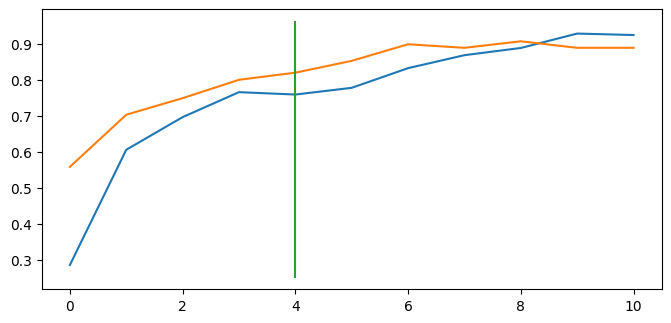

In [251]:
compare_history(original_history = history_10_percent_data_aug,
                new_history = history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4 : Fine-tuning an existing model all ot the data

In [ ]:
# Downlad and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


In [ ]:
# setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"


In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_aldd_data")

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_dmoe ="categorical",
                                                                                 image_size = IMG_SIZE)
# Note : this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

In [ ]:
results_fine_tune_10_percent

In [ ]:
# Create a new instance of mode_2 for Experiment $
model_2 = create_base_model(learning_rate = 0.001) # 10x lower learning rate for fine-tuning

In [ ]:
# load previously checkpointed weights
model_2.load_wights(checkpoint_path)

In [ ]:
model_2.summary()

In [ ]:
print(len(model_2.trainable_variables))

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)



In [ ]:
# unfreeze the top 10 layers in model_2's base model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeae all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Check which layers are tuneable in the base model
for layer_nubmer, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
# Recompile the model (always recompile after any adjustments to a model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # lr is 10x lower than before for fine-tuning
                metrics = ["accuracy"])

In [ ]:
# continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs +5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           initial_epochs = history_10_percent_data_aug.epoch[-1],
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           callbacks = [create_tensorboard_callback("trainsfer_learning","full_10_classes_fine_tune_last_10")]
                                           )

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
results_fine_tune_10_percent


In [ ]:
# How did fine-tuning go with more data?
compare_history(orignal_history = history_10_percent_data_aug,
                new_history = history_fine_10_classes_full,
                initial_epochs = 5)